In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
df = pd.read_csv("/home/vagabond/Documents/Goals/SmartChainX-Supply-Chain-Optimizer/01_Demand_Forecasting/demand-forecasting-kernels-only/train.csv")

In [4]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.head()


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [8]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [9]:
df = df.sort_values(['store','item','sales','date'])

In [10]:
df.head()

,date,store,item,sales
447,2014-03-24,1,1,4
1091,2015-12-28,1,1,4
14,2013-01-15,1,1,5
345,2013-12-12,1,1,5
363,2013-12-30,1,1,5


In [11]:
df.set_index('date',inplace=True)

In [12]:
df['sales'].describe()
df['store'].nunique()

df['item'].nunique()


50

<Axes: title={'center': 'Sales for Item 1'}, xlabel='date'>

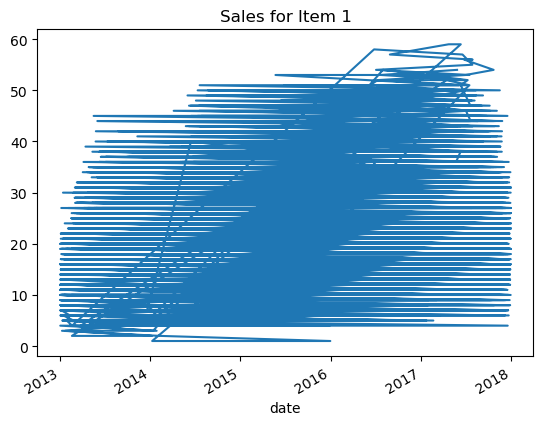

In [13]:
df[df['item'] == 1]['sales'].plot(title='Sales for Item 1')

In [14]:
df['day'] = df.index.day

In [15]:
df['month'] = df.index.month

In [16]:
df['year'] = df.index.year

In [17]:
df['dayofweek'] = df.index.dayofweek

In [18]:
df.head()

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2014-03-24,1,1,4,24,3,2014,0
2015-12-28,1,1,4,28,12,2015,0
2013-01-15,1,1,5,15,1,2013,1
2013-12-12,1,1,5,12,12,2013,3
2013-12-30,1,1,5,30,12,2013,0


<Axes: xlabel='date'>

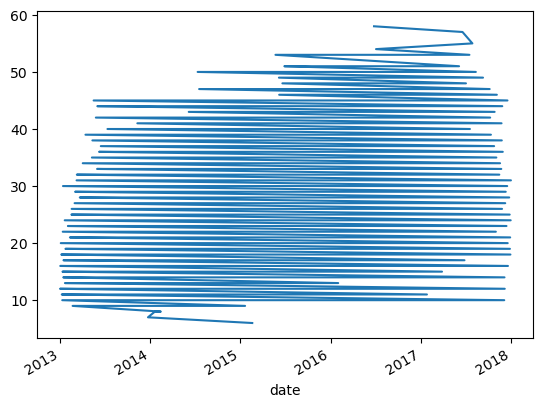

In [19]:
store_item = df[(df['item'] == 1) & (df['store'] == 2)]

store_item['sales'].plot()

# Lets create the ML model now

In [20]:
df_filtered = df[(df['store'] == 1) & (df['item'] == 1)].copy()

In [21]:
for lag in [3,7,14]:
    df_filtered[f'sales_lag_{lag}'] = df_filtered['sales'].shift(lag)

In [22]:
df_filtered["day"] = df_filtered.index.day
df_filtered["month"] = df_filtered.index.month
df_filtered["dayofweek"] = df_filtered.index.dayofweek

In [23]:
df_filtered.dropna(inplace=True)

In [24]:
train = df_filtered.iloc[:-30]
test = df_filtered.iloc[-30:]


In [25]:
X_train = train.drop('sales',axis=1)
Y_train = train['sales']


In [26]:
X_test = test.drop('sales',axis=1)
Y_test = test['sales']

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [28]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [29]:
preds = model.predict(X_test)

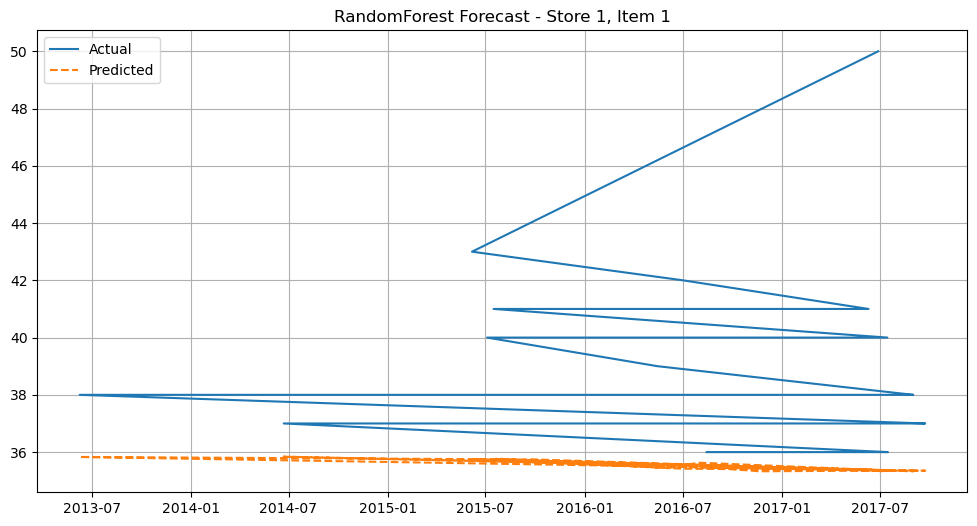

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, Y_test, label="Actual")
plt.plot(test.index, preds, label="Predicted", linestyle='--')
plt.title("RandomForest Forecast - Store 1, Item 1")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
test['predicted_sales'] = preds
test[['sales', 'predicted_sales']].to_csv("forecast_rf_output.csv")

/tmp/ipykernel_8444/1701448443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_sales'] = preds


# Now let's do for the Multi-store segment

In [33]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

In [38]:
df_all = df.copy()

In [39]:
df_all['date'] = df_all.index


In [40]:
results = []


In [41]:
for store in df_all['store'].unique():
    for item in df_all['item'].unique():
        df_filtered = df_all[(df_all['store'] == store) & (df_all['item'] == item)].copy()
        
        for lag in [1, 7, 14]:
            df_filtered[f'sales_lag_{lag}'] = df_filtered['sales'].shift(lag)
        
        df_filtered['day'] = df_filtered.index.day
        df_filtered['month'] = df_filtered.index.month
        df_filtered['dayofweek'] = df_filtered.index.dayofweek
        df_filtered.dropna(inplace=True)
        
        if len(df_filtered) < 60:
            continue  # skip small data windows

        train = df_filtered.iloc[:-30]
        test = df_filtered.iloc[-30:]

        X1_train = train.drop(['sales', 'store', 'item', 'date'], axis=1)
        y1_train = train['sales']
        X1_test = test.drop(['sales', 'store', 'item', 'date'], axis=1)


        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X1_train, y1_train)
        preds = model.predict(X1_test)

        test = test.copy()
        test['predicted_sales'] = preds
        test['store'] = store
        test['item'] = item
        results.append(test[['date', 'store', 'item', 'sales', 'predicted_sales']])

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [43]:
# Combine all
forecast_df = pd.concat(results)
forecast_df.to_csv("all_forecast.csv", index=False)

In [46]:
rmse = np.sqrt(mean_squared_error(Y_test, preds))
mae = mean_absolute_error(Y_test, preds)
r2 = r2_score(Y_test, preds)

In [47]:
print(f"📈 RMSE: {rmse:.2f}")
print(f"📊 MAE: {mae:.2f}")
print(f"🧠 R² Score: {r2:.4f}")

📈 RMSE: 79.34
📊 MAE: 79.30
🧠 R² Score: -823.8483
